TM simulation of a plane wave source impinging on a dielectric cylinder Analysis

In [2]:
import numpy as np
from math import sin, exp, sqrt, atan2, cos, pi
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D, get_test_data

In [3]:
ie = 50
je = 50
ic = int(ie / 2 - 1)
jc = int(je / 2 - 1)
ia = 7
ib = ie - ia - 1
ja = 7
jb = je - ja - 1
ez = np.zeros((ie, je))
dz = np.zeros((ie, je))
hx = np.zeros((ie, je))
hy = np.zeros((ie, je))
iz = np.zeros((ie, je))
ihx = np.zeros((ie, je))
ihy = np.zeros((ie, je))
ez_inc = np.zeros(je)
hx_inc = np.zeros(je)
ddx = 0.01 # Cell size
dt = ddx / 6e8 # Time step size
number_of_frequencies = 3
freq = np.array((50e6, 300e6, 700e6))
arg = 2 * np.pi * freq * dt
real_in = np.zeros(number_of_frequencies)
imag_in = np.zeros(number_of_frequencies)
real_pt = np.zeros((number_of_frequencies, ie, je))
imag_pt = np.zeros((number_of_frequencies, ie, je))
amp = np.zeros((number_of_frequencies, je))
phase = np.zeros((number_of_frequencies, je))
gaz = np.ones((ie, je))
gbz = np.zeros((ie, je))

# Specify the dielectric cylinder
epsr = 30
sigma = 0.3
radius = 10

# Create Dielectric Profile
epsz = 8.854e-12
for j in range(ja, jb):
    for i in range(ia, ib):
        xdist = (ic - i)
        ydist = (jc - j)
        dist = sqrt(xdist ** 2 + ydist ** 2)
        if dist <= radius:
            gaz[i, j] = 1 / (epsr + (sigma * dt / epsz))
            gbz[i, j] = (sigma * dt / epsz)
boundary_low = [0, 0]
boundary_high = [0, 0]

# Calculate the PML parameters
gi2 = np.ones(ie)
gi3 = np.ones(ie)
fi1 = np.zeros(ie)
fi2 = np.ones(ie)
fi3 = np.ones(ie)
gj2 = np.ones(je)
gj3 = np.ones(je)
fj1 = np.zeros(je)
fj2 = np.ones(je)
fj3 = np.ones(je)

# Create the PML as described in Section 3.2
npml = 8
for n in range(npml):
    xnum = npml - n
    xd = npml
    xxn = xnum / xd
    xn = 0.33 * xxn ** 3
    gi2[n] = 1 / (1 + xn)
    gi2[ie - 1 - n] = 1 / (1 + xn)
    gi3[n] = (1 - xn) / (1 + xn)
    gi3[ie - 1 - n] = (1 - xn) / (1 + xn)
    gj2[n] = 1 / (1 + xn)
    gj2[je - 1 - n] = 1 / (1 + xn)
    gj3[n] = (1 - xn) / (1 + xn)
    gj3[je - 1 - n] = (1 - xn) / (1 + xn)
    xxn = (xnum - 0.5) / xd
    xn = 0.33 * xxn ** 3
    fi1[n] = xn
    fi1[ie - 2 - n] = xn
    fi2[n] = 1 / (1 + xn)
    fi2[ie - 2 - n] = 1 / (1 + xn)
    fi3[n] = (1 - xn) / (1 + xn)
    fi3[ie - 2 - n] = (1 - xn) / (1 + xn)
    fj1[n] = xn
    fj1[je - 2 - n] = xn
    fj2[n] = 1 / (1 + xn)
    fj2[je - 2 - n] = 1 / (1 + xn)
    fj3[n] = (1 - xn) / (1 + xn)
    fj3[je - 2 - n] = (1 - xn) / (1 + xn)

# Pulse Parameters
t0 = 20
spread = 8
nsteps = 500
# Dictionary to keep track of desired points for plotting
plotting_points = [
{'label': 'a', 'num_steps': 25, 'data_to_plot': None},
{'label': 'b', 'num_steps': 50, 'data_to_plot': None},
{'label': 'c', 'num_steps': 75, 'data_to_plot': None},
{'label': 'd', 'num_steps': 100, 'data_to_plot': None},
]

In [4]:
# Main FDTD Loop
for time_step in range(1, nsteps + 1):
    # Incident Ez values
    for j in range(1, je):
        ez_inc[j] = ez_inc[j] + 0.5 * (hx_inc[j - 1] - hx_inc[j])
    
    if time_step < 3 * t0:
        for m in range(number_of_frequencies):
            real_in[m] = real_in[m] + cos(arg[m] * time_step) \
            * ez_inc[ja - 1]
            imag_in[m] = imag_in[m] - sin(arg[m] * time_step) \
            * ez_inc[ja - 1]

    # Absorbing Boundary Conditions
    ez_inc[0] = boundary_low.pop(0)
    boundary_low.append(ez_inc[1])

    ez_inc[je - 1] = boundary_high.pop(0)
    boundary_high.append(ez_inc[je - 2])

    # Calculate the Dz field
    for j in range(1, je):
        for i in range(1, ie):
            dz[i, j] = gi3[i] * gj3[j] * dz[i, j] + \
            gi2[i] * gj2[j] * 0.5 * \
            (hy[i, j] - hy[i - 1, j] -
            hx[i, j] + hx[i, j - 1])
    
    # Source
    pulse = exp(-0.5 * ((t0 - time_step) / spread) ** 2)
    ez_inc[3] = pulse

    # Incident Dz values
    for i in range(ia, ib + 1):
        dz[i, ja] = dz[i, ja] + 0.5 * hx_inc[ja - 1]
        dz[i, jb] = dz[i, jb] - 0.5 * hx_inc[jb]

    # Calculate the Ez field
    for j in range(0, je):
        for i in range(0, ie):
            ez[i, j] = gaz[i, j] * (dz[i, j] - iz[i, j])
            iz[i, j] = iz[i, j] + gbz[i, j] * ez[i, j]

    # Calculate the Fourier transform of Ex
    for j in range(0, je):
        for i in range(0, ie):
            for m in range(0, number_of_frequencies):
                real_pt[m, i, j] = real_pt[m, i, j] + \
                cos(arg[m]*time_step)*ez[i,j]
                imag_pt[m, i, j] = imag_pt[m, i, j] - \
                sin(arg[m] * time_step) * ez[i, j]

    # Calculate the Incident Hx
    for j in range(0, je - 1):
        hx_inc[j] = hx_inc[j] + 0.5 * (ez_inc[j] - ez_inc[j + 1])

    # Calculate the Hx field
    for j in range(0, je - 1):
        for i in range(0, ie - 1):
            curl_e = ez[i, j] - ez[i, j + 1]
            ihx[i, j] = ihx[i, j] + curl_e
            hx[i, j] = fj3[j] * hx[i, j] + fj2[j] * \
            (0.5 * curl_e + fi1[i] * ihx[i, j])

    # Incident Hx values
    for i in range(ia, ib + 1):
        hx[i, ja - 1] = hx[i, ja - 1] + 0.5 * ez_inc[ja]
        hx[i, jb] = hx[i, jb] - 0.5 * ez_inc[jb]

    # Calculate the Hy field
    for j in range(0, je):
        for i in range(0, ie - 1):
            curl_e = ez[i, j] - ez[i + 1, j]
            ihy[i, j] = ihy[i, j] + curl_e
            hy[i, j] = fi3[i] * hy[i, j] - fi2[i] * \
            (0.5 * curl_e + fj1[j] * ihy[i, j])

    # Incident Hy values
    for j in range(ja, jb + 1):
        hy[ia - 1, j] = hy[ia - 1, j] - 0.5 * ez_inc[j]
        hy[ib, j] = hy[ib, j] + 0.5 * ez_inc[j]

    # Save data at certain points for later plotting
    for plotting_point in plotting_points:
        if time_step == plotting_point['num_steps']:
            plotting_point['data_to_plot'] = np.copy(ez)

    # Calculate the Fourier amplitude and phase of the incident pulse
    amp_in = np.sqrt(real_in ** 2 + imag_in ** 2)
    phase_in = np.arctan2(imag_in, real_in)

    # This accounts for the offset between this program and the
    #Bessel outputs
    phase_offset = (0, 0.35 * pi, 0.9 * pi)

    # Calculate the Fourier amplitude and phase of the total field
    for m in range(number_of_frequencies):
        for j in range(ja, jb + 1):
            if gaz[ic, j] < 1:
                amp[m, j]=1/ (amp_in[m]) * sqrt(real_pt[m, ic, j] ** 2 +
                imag_pt[m, ic, j] ** 2)
                phase[m, j] = atan2(imag_pt[m, ic, j], real_pt[m, ic, j]) \
                - pi - phase_in[m] + phase_offset[m]
                if phase[m, j] < -2 * pi:
                    phase[m, j] += 2 * pi
                if phase[m, j] > 0:
                    phase[m, j] -= 2 * pi

C:\Users\mazzo\AppData\Local\Temp\ipykernel_13160\1463129981.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  amp[m, j]=1/ (amp_in[m]) * sqrt(real_pt[m, ic, j] ** 2 +
C:\Users\mazzo\AppData\Local\Temp\ipykernel_13160\1463129981.py:100: RuntimeWarning: invalid value encountered in double_scalars
  amp[m, j]=1/ (amp_in[m]) * sqrt(real_pt[m, ic, j] ** 2 +


C:\Users\mazzo\AppData\Local\Temp\ipykernel_13160\1495939280.py:31: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 11


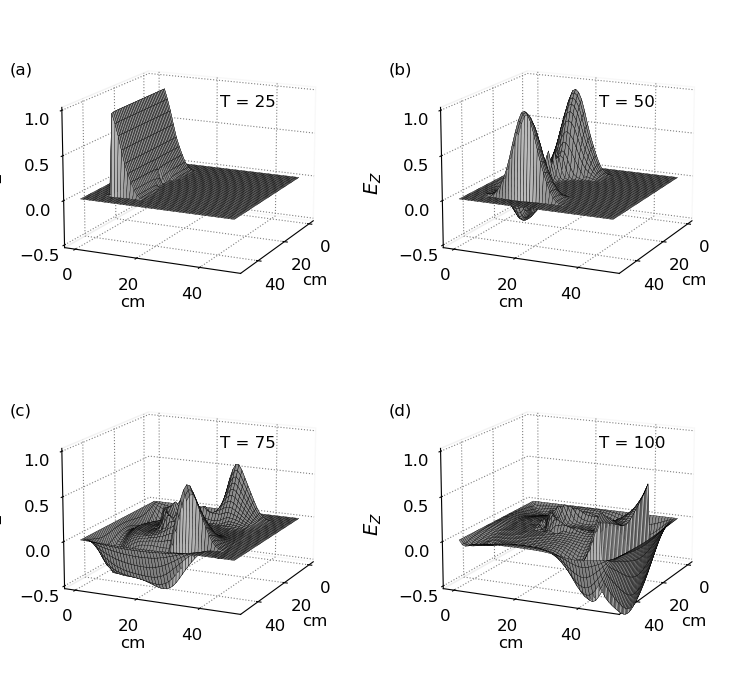

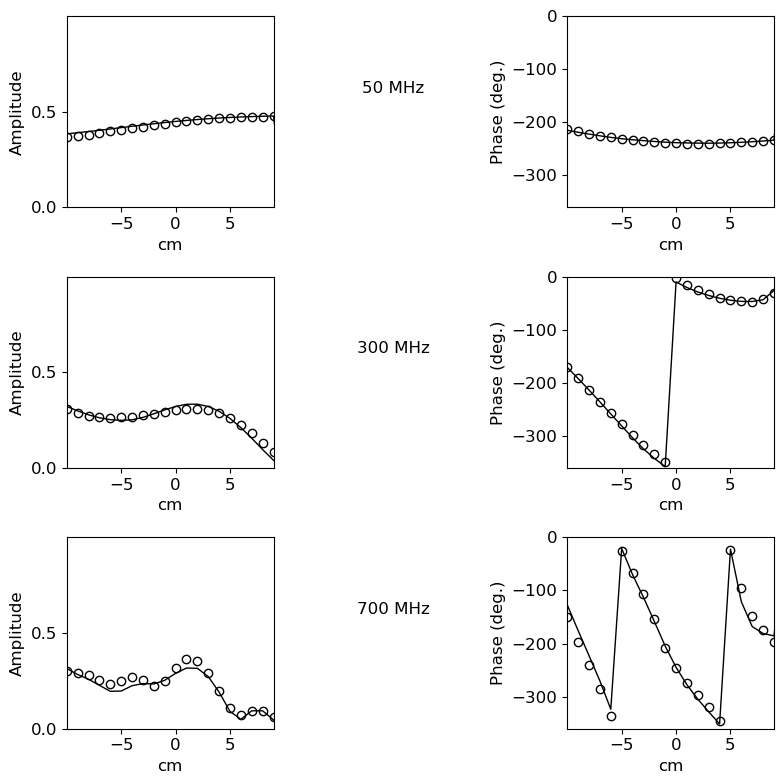

In [5]:
# Plot Fig. 3.9
plt.rcParams['font.size'] = 12
plt.rcParams['grid.color'] = 'gray'
plt.rcParams['grid.linestyle'] = 'dotted'
fig = plt.figure(figsize=(8, 7))

X, Y = np.meshgrid(range(je), range(ie))

def plot_e_field(ax, data, timestep, label):
#3d Plot of E field at a single timestep
    ax.set_zlim(-0.5, 1)
    ax.view_init(elev=15., azim=25)
    ax.plot_surface(Y, X, data, rstride=1, cstride=1,
        color='white',
        edgecolor='black', linewidth=.25)
    ax.zaxis.set_rotate_label(False)
    ax.set_zlabel(r' $E_{Z}$', rotation=90, labelpad=10,
        fontsize=14)
    ax.set_zticks([-0.5, 0, 0.5, 1])
    ax.set_xlabel('cm')
    ax.set_ylabel('cm')
    ax.set_xticks(np.arange(0, 50, step=20))
    ax.set_yticks(np.arange(0, 50, step=20))
    ax.text2D(0.6, 0.7, "T = {}".format(timestep),
        transform=ax.transAxes)
    ax.xaxis.pane.fill = ax.yaxis.pane.fill = \
    ax.zaxis.pane.fill = False
    plt.gca().patch.set_facecolor('white')
    ax.text2D(-0.05, 0.8, "({})".format(label), transform=ax.
    transAxes)
    ax.dist = 11
    

#Plot the E field at each of the four time steps saved earlier
for subplot_num, plotting_point in enumerate(plotting_points):
    ax = fig.add_subplot(2, 2, subplot_num + 1, projection='3d')
    plot_e_field(ax, plotting_point['data_to_plot'],
        plotting_point['num_steps'], plotting_point['label'])

fig.tight_layout()
plt.show()

# Plot Fig. 3.10
plt.rcParams['font.size'] = 12
fig = plt.figure(figsize=(8, 8))
compare_array = np.arange(-10, 10, step=1)
x_array = np.arange(-25, 25, step=1)
# The data here was generated with the Bessel function expansion program
compare_amp = np.array(
    [[0.3685, 0.3741, 0.3808, 0.3885, 0.3967, 0.4051, 0.4136,
    0.4220, 0.4300, 0.4376, 0.4445, 0.4507, 0.4562, 0.4610,
    0.4650, 0.4683, 0.4708, 0.4728, 0.4742, 0.4753],
    [0.3089, 0.2887, 0.2743, 0.2661, 0.2633, 0.2646, 0.2689,
    0.2754, 0.2837, 0.2932, 0.3023, 0.3090, 0.3107, 0.3048,
    0.2893, 0.2633, 0.2272, 0.1825, 0.1326, 0.0830],
    [0.2996, 0.2936, 0.2821, 0.2526, 0.2336, 0.2518, 0.2709,
    0.2539, 0.2236, 0.2479, 0.3161, 0.3622, 0.3529, 0.2909,
    0.1990, 0.1094, 0.0727, 0.0922, 0.0935, 0.0605]])

compare_phase = np.array(
    [[-212.139, -216.837, -221.089, -224.889, -228.237,
    -231.145, -233.624, -235.691, -237.360, -238.657,
    -239.561, -240.118, -240.324, -240.188, -239.713,
    -238.904, -237.761, -236.286, -234.477, -232.333],
    [-169.783, -191.511, -213.645, -235.729, -257.262,
    -277.892, -297.459, -315.879, -333.025, -348.844,
    -2.666, -14.776, -24.963, -33.243, -39.655, -44.194,
    -46.711, -46.718, -42.781, -30.063],
    [-149.660, -196.637, -240.366, -285.484, -336.898,
    -26.642, -67.400, -106.171, -153.880, -207.471,
    -246.319, -274.083, -297.293, -319.952, -345.740,
    -24.116, -94.689, -147.581, -174.128, -196.241]])

def plot_amp(ax, data, compare, freq):
    #Plot the Fourier transform amplitude at a specific frequency
    ax.plot(x_array, data, color='k', linewidth=1)
    ax.plot(compare_array, compare, 'ko', mfc='none',
    linewidth=1)
    plt.xlabel('cm')
    plt.ylabel('Amplitude')
    plt.xticks(np.arange(-5, 10, step=5))
    plt.xlim(-10, 9)
    plt.yticks(np.arange(0, 1, step=0.5))
    plt.ylim(0, 1)
    ax.text(20, 0.6, '{} MHz'.format(int(freq / 1e6)),
horizontalalignment='center')
def plot_phase(ax, data, compare):
    #Plot the Fourier transform phase at a specific frequency
    ax.plot(x_array, data * 180 / pi, color='k', linewidth=1)
    ax.plot(compare_array, compare, 'ko', mfc='none', linewidth=1)
    plt.xlabel('cm')
    plt.ylabel('Phase (deg.)')
    plt.xticks(np.arange(-5, 10, step=5))
    plt.xlim(-10, 9)
    plt.yticks([-300, -200, -100, 0])
    plt.ylim(-360, 0)

# Plot the results of the Fourier transform at each of the frequencies
for m in range(number_of_frequencies):
    ax = fig.add_subplot(3, 2, m * 2 + 1)
    plot_amp(ax, amp[m], compare_amp[m], freq[m])
    ax = fig.add_subplot(3, 2, m * 2 + 2)
    plot_phase(ax, phase[m], compare_phase[m])
    
plt.tight_layout()
plt.show()